<a href="https://colab.research.google.com/github/hitts2016/CLIP_ts/blob/main/docs/Interacting_with_open_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with open_clip

This is a self-contained notebook that shows how to download and run open_clip models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

## Preparation for colab

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
! pip install open_clip_torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [4]:
import numpy as np
import torch

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import open_clip
open_clip.list_pretrained()

In [6]:
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/718M [00:00<?, ?B/s]

In [7]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 179,385,345
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [8]:
preprocess

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    <function _convert_to_rgb at 0x7d441d596700>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `tokenizer.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [9]:
from open_clip import tokenizer

In [10]:
tokenizer.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [ ]:
!pip install pooch
import skimage
import os
import pooch

skimage.data.download_all()  # Download all data if it's not already present

# Verify the download location
print(f"Data directory: {skimage.data_dir}")
# Optionally, set the data directory manually
# os.environ["SKIMAGE_DATADIR"] = "your/path/to/data"

# ... (rest of your code) ...

original_images = []
images = []
texts = []
print(skimage.data_dir)
plt.figure(figsize=(16, 5))
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

ihc.png
microaneurysms.png
camera.png
coffee.png
grass.png
skin.jpg
bw_text.png
hubble_deep_field.jpg
logo.png
green_palette.png
page.png
horse.png
astronaut.png
cell.png
palette_gray.png
chessboard_RGB.png
rocket.jpg
motorcycle_left.png
checker_bilevel.png
eagle.png
motorcycle_right.png
truncated.jpg
foo3x5x4indexed.png
coins.png
chessboard_GRAY.png
phantom.png
palette_color.png
chelsea.png
gravel.png
color.png
brick.png
retina.jpg
clock_motion.png
moon.png
text.png


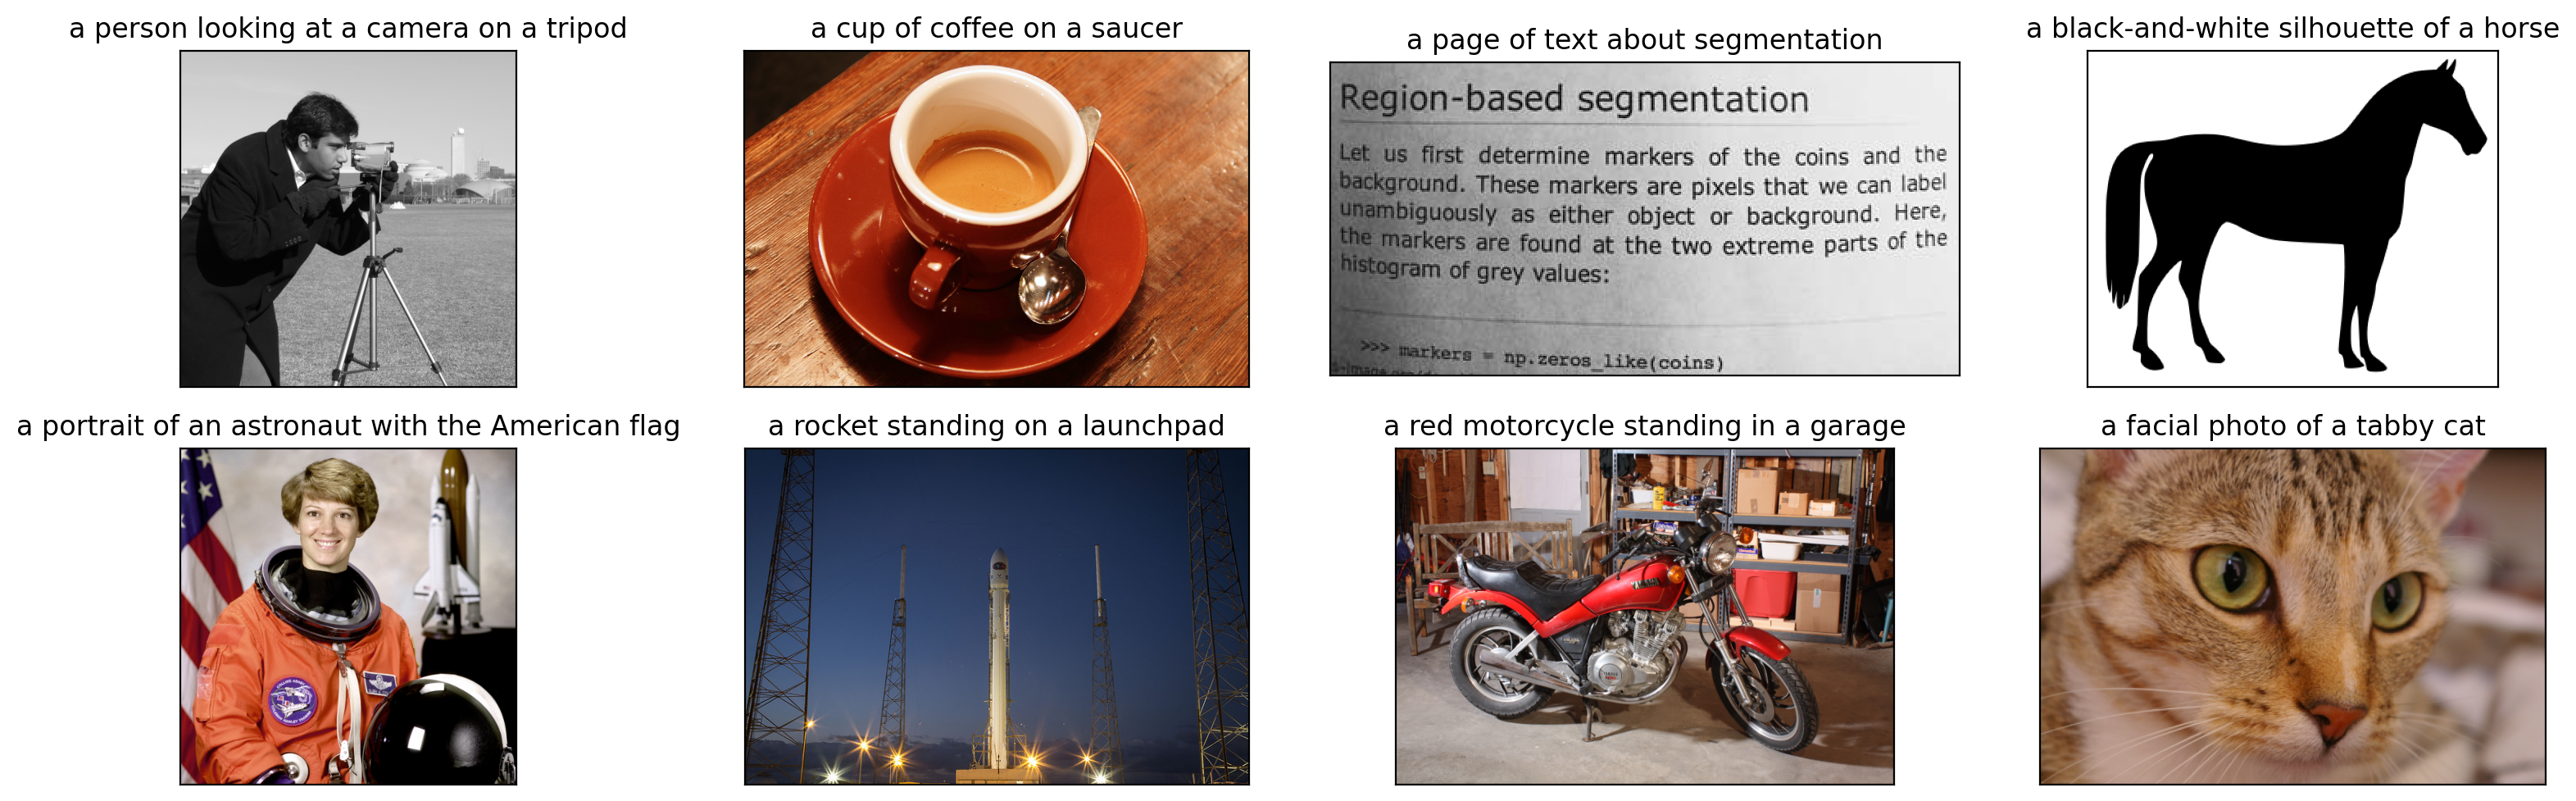

In [27]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    print(filename)
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [28]:
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])

In [30]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    print(image_features)
    text_features = model.encode_text(text_tokens).float()
    print(text_features)

tensor([[-0.1962, -0.1761,  0.2977,  ..., -0.2350,  0.0779, -0.1610],
        [-0.0204, -0.6345,  0.1079,  ..., -0.0038, -0.3437,  0.5685],
        [ 0.2319, -0.6790,  0.3831,  ...,  0.2883,  0.4286,  0.1453],
        ...,
        [-0.4088, -0.4839,  0.0122,  ...,  0.8186, -0.1730, -0.1373],
        [-0.1107, -0.6318, -0.2033,  ..., -0.0952, -0.3795,  0.0461],
        [-0.1148, -0.1219, -0.0549,  ..., -0.2195,  0.1279,  0.0921]])
tensor([[ 0.0019,  1.1128,  0.4260,  ...,  0.4407, -0.1833, -0.1811],
        [-0.2004, -0.7185, -0.3038,  ...,  0.2308,  0.3412,  0.5526],
        [ 0.9194,  0.0239,  0.6000,  ...,  0.5307, -0.6275,  0.0406],
        ...,
        [-0.6328,  0.6676, -0.0796,  ...,  0.2190, -0.7540, -0.4730],
        [ 0.1608, -0.1820, -0.2285,  ...,  0.4528,  0.2604,  0.2878],
        [ 0.0281, -0.2872,  0.4428,  ...,  0.2564,  0.7900,  0.2857]])


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [38]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

print(similarity)

[[0.37708324 0.13241276 0.24773788 0.19604021 0.21901827 0.18620592
  0.15656449 0.20992243]
 [0.1835329  0.38444042 0.21739525 0.15977822 0.16050339 0.13956387
  0.12678292 0.20921636]
 [0.17493631 0.1829874  0.4613698  0.1681695  0.10389605 0.13468544
  0.10693577 0.19786271]
 [0.23668596 0.11653851 0.21662478 0.4149198  0.11758471 0.12159444
  0.12202682 0.10103817]
 [0.202102   0.09797022 0.14564177 0.09362978 0.33378288 0.24449544
  0.12368558 0.14813931]
 [0.24491915 0.1419871  0.21354052 0.14892668 0.24165055 0.35408366
  0.19798179 0.17956492]
 [0.09661007 0.11907539 0.16726863 0.12074071 0.15568034 0.12680317
  0.4026854  0.11536806]
 [0.14888838 0.15964663 0.19491908 0.14729051 0.15946881 0.11254367
  0.11608009 0.40056562]]


Text(0.5, 1.0, 'Cosine similarity between text and image features')

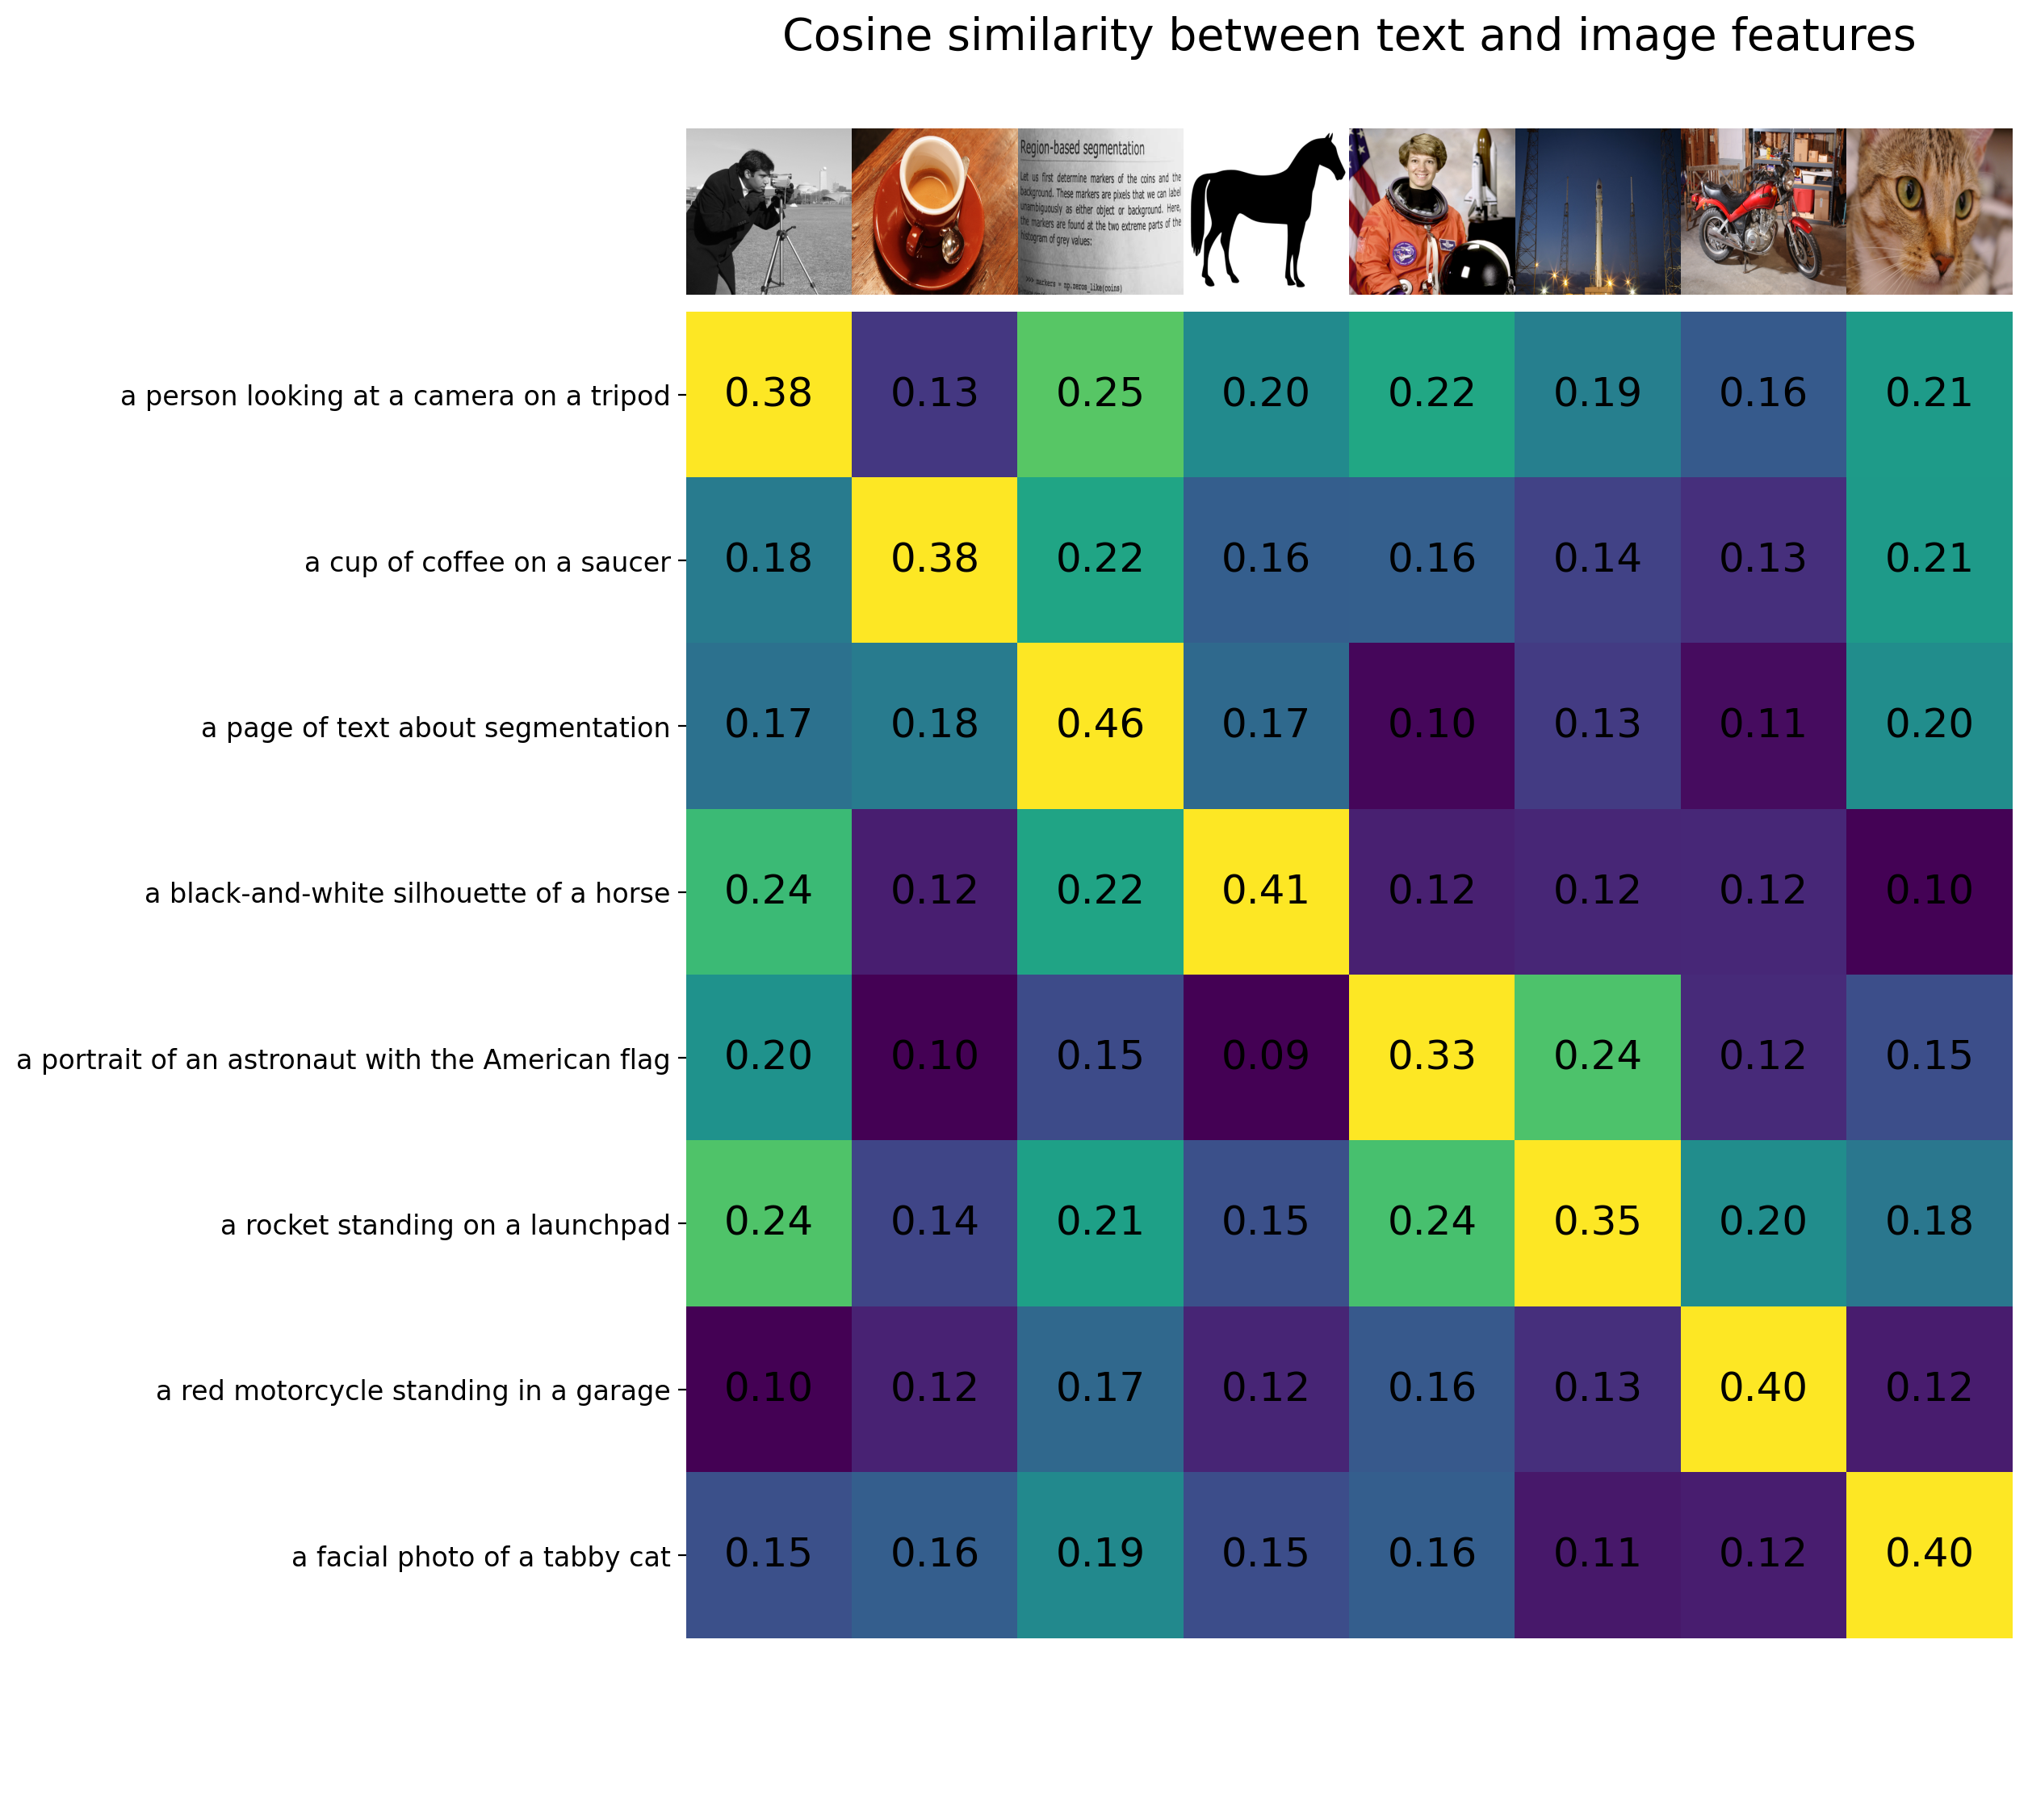

In [51]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=18)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [52]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:05<00:00, 30.1MB/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
for label in cifar100.classes:
  print(label)
text_tokens = tokenizer.tokenize(text_descriptions)
print(text_tokens[0])
print(text_tokens[12])

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

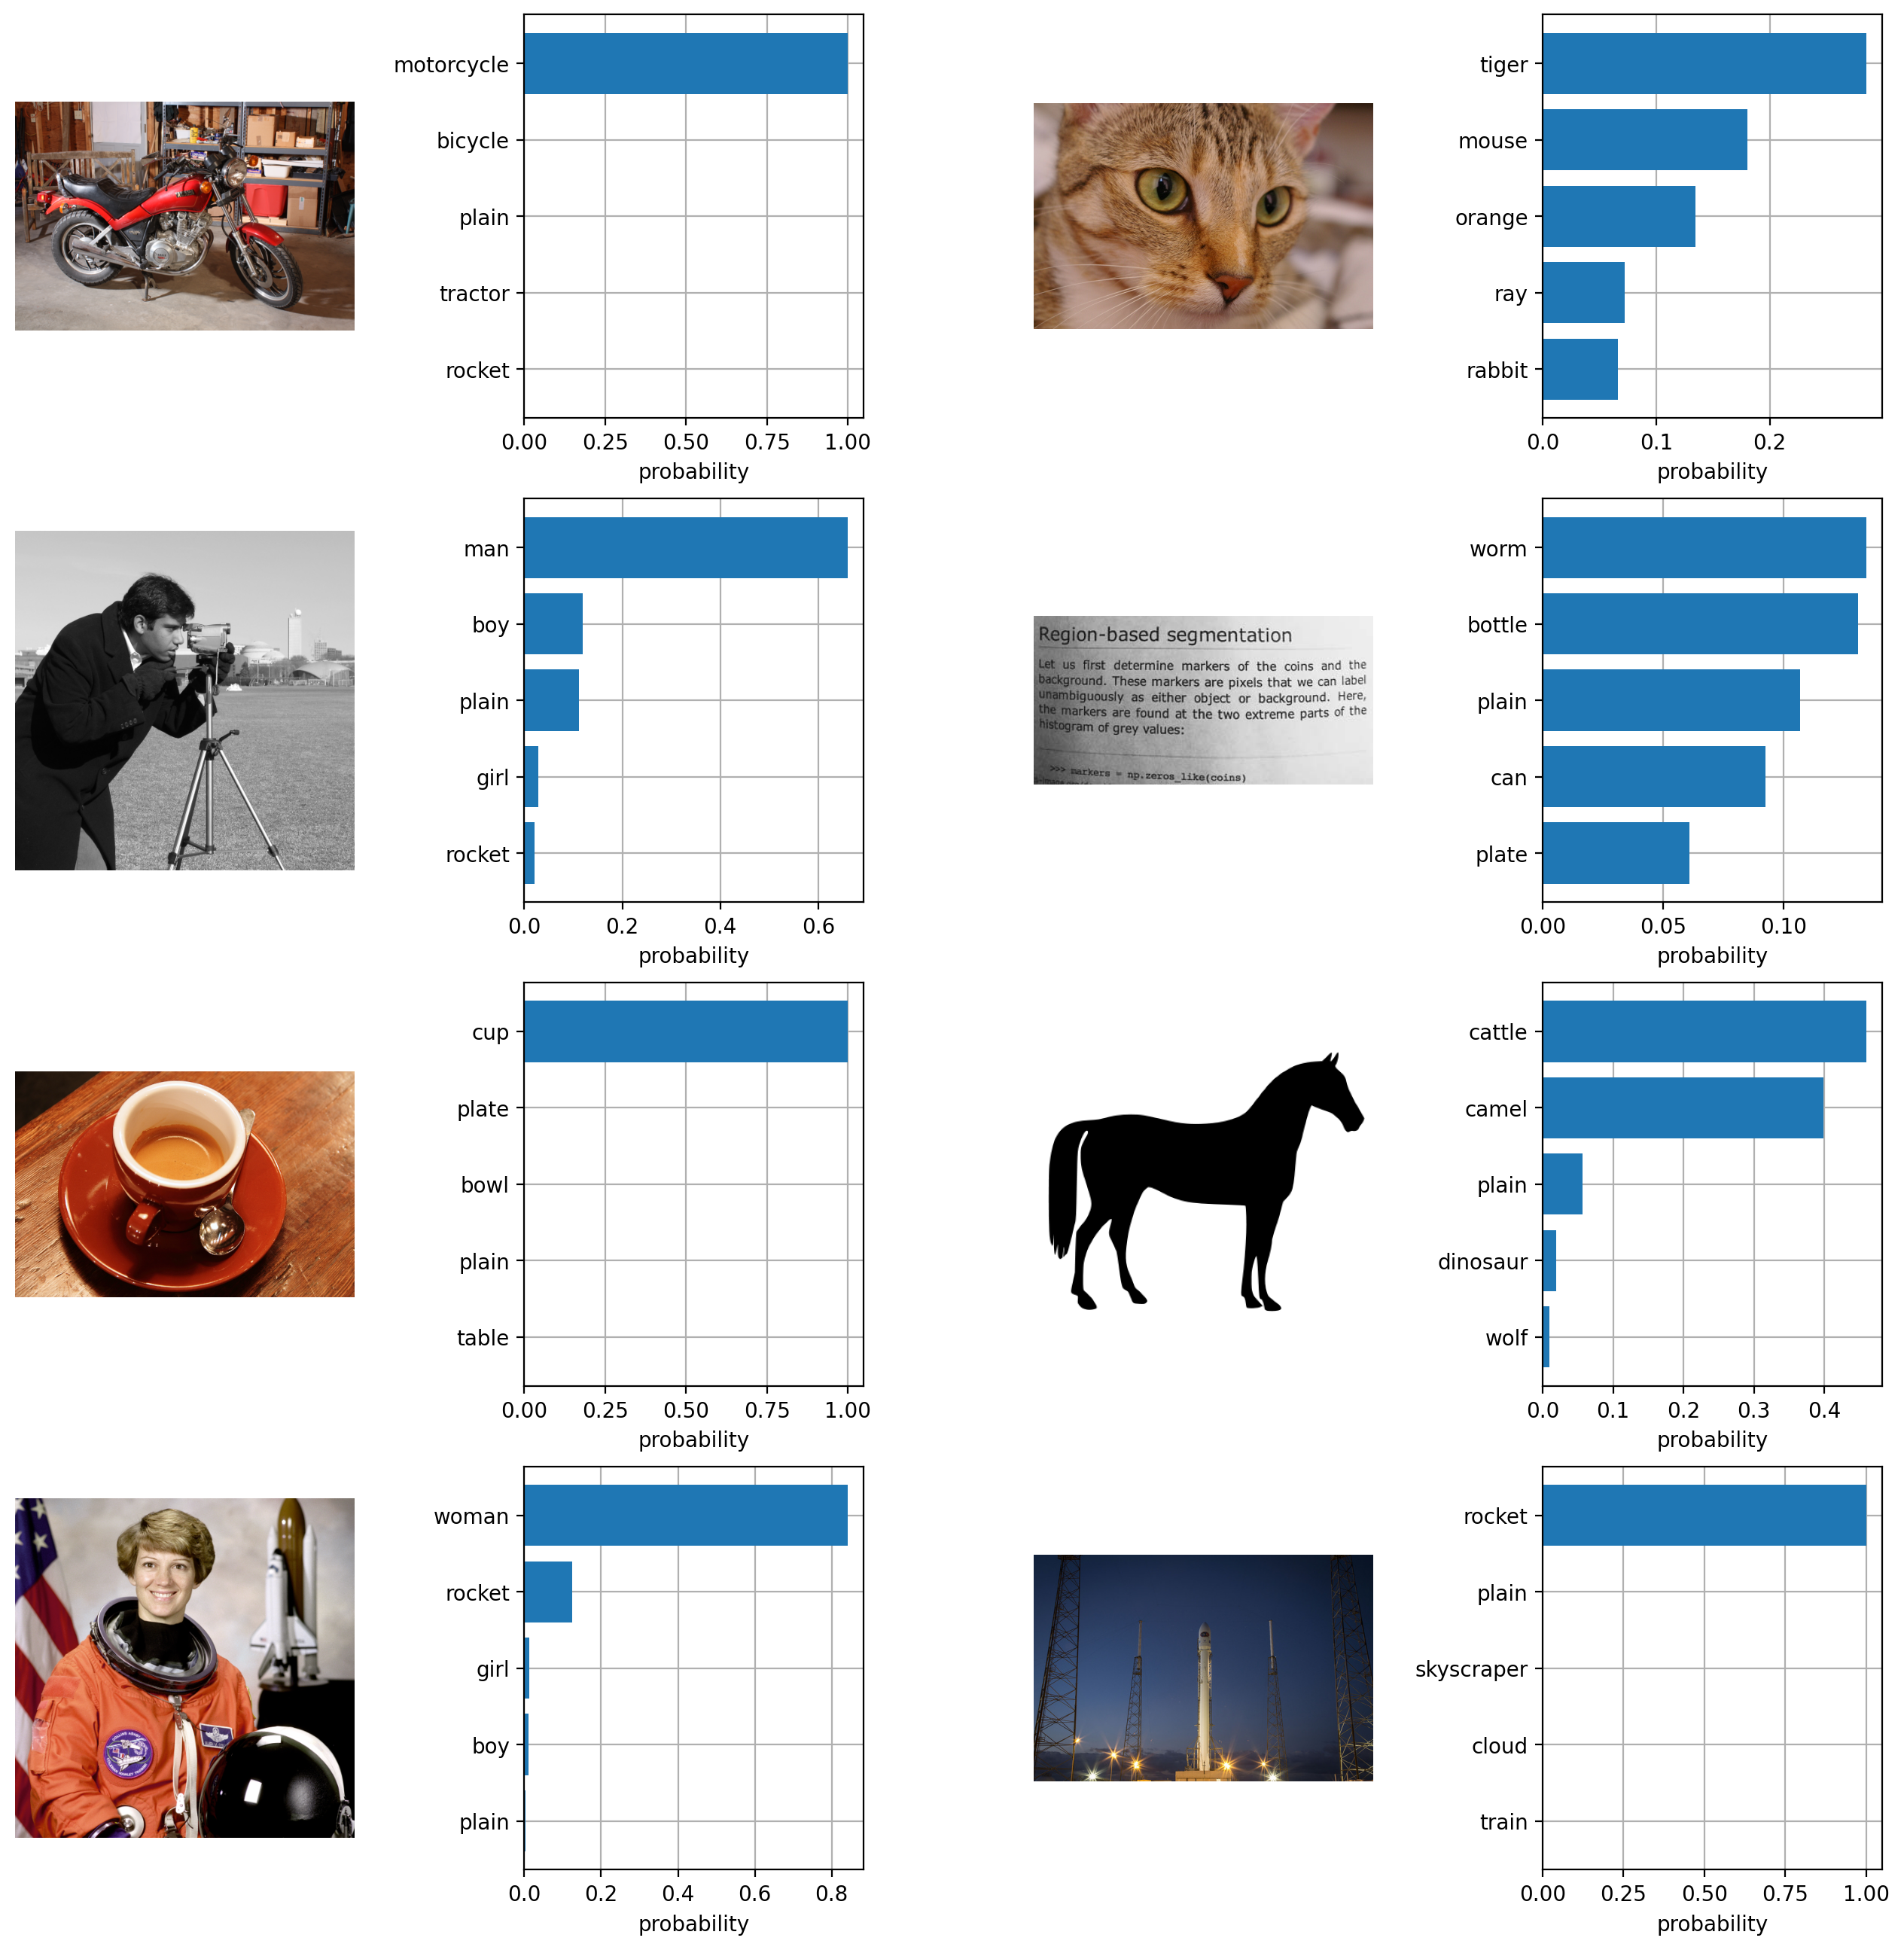

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()